# What is P300 ??

## 🧠 الـ P300 هو إيه؟





* هو **موجة كهربائية (إشارة مميزة)** بتظهر في الـ EEG.
* بتظهر تقريبًا بعد **300 ملي ثانية (0.3 ثانية)** من لحظة ظهور Stimulus مهم للشخص.
* عشان كده اسمها:

  * **P** = موجة إيجابية (Positive deflection).
  * **300** = حوالي 300 ms بعد الـ stimulus.

---

### 📌 مثال بسيط:

تخيل قدامك شاشة فيها حروف (زي لوحة مفاتيح).

* كل شوية صف أو عمود من الحروف يضوي (وميض).
* إنت مركز على حرف "A".
* لما يضوي العمود أو الصف اللي فيه "A" → يحصل تركيز عقلي → يظهر في المخ **إشارة P300** بعد ~300ms.
* لما يضوي عمود/صف مالوش علاقة بـ "A" → مفيش P300 واضحة.

---

### ✨ خصائص P300:

1. **الزمن (Latency):** بتبدأ بعد 250–300ms وتوصل ذروتها حوالي 400–600ms.
2. **المكان (Scalp location):** أوضح ما يكون في القنوات المركزية والجداريّة (Cz, Pz).
3. **الشكل:** موجة إيجابية (طلعة فوق baseline) مقارنةً بالإشارات العادية.
4. **المعنى:** المخ بيقول "أيوه! لقيت الحاجة اللي كنت بدوّر عليها".

---

### 🎯 الاستخدامات

* **BCI Spellers**: يكتب الشخص بالحروف من خلال التركيز.
* **Emergency Stop**: لو مركز على كلمة "STOP" → النظام يلتقط P300 → يوقف الكرسي أو الروبوت.
* **اختبارات الانتباه والذاكرة**: لأنها مرتبطة بالـ *cognitive processing*.

---

### 🔑 الخلاصة

الـ **P300** = بصمة دماغية بتظهر بعد ما تشوف Stimulus مهم.
هي موجة إيجابية في الـ EEG حوالين 300ms، نقدر نستخدمها كـ **إشارة تحكم** (زي YES/NO أو اختيار حرف).

## What Data contain ?

# Code

In [ ]:
!pip install scipy h5py pandas matplotlib --quiet

from google.colab import files
import io
import os
import scipy.io
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint


In [ ]:
# cell 3: دوال تحميل واستكشاف
def load_mat_general(path_or_bytes):
    """
    Accepts either a filesystem path (str) or raw bytes (from files.upload()).
    Returns: dict-like mapping variable_name -> python object (np.array, dict, etc.)
    """
    # إذا تم إعطاء bytes من files.upload()
    if isinstance(path_or_bytes, (bytes, bytearray)):
        # احفظ مؤقتاً لقراءة بواسطة h5py/scipy
        tmp = '/content/_tmp_uploaded.mat'
        with open(tmp, 'wb') as f:
            f.write(path_or_bytes)
        path = tmp
    else:
        path = path_or_bytes

    # حاول باستخدام scipy أولاً (يدعم معظم ملفات non-v7.3)
    try:
        mat = scipy.io.loadmat(path, struct_as_record=False, squeeze_me=True)
        # تنظيف المفاتيح الافتراضية
        mat = {k: v for k, v in mat.items() if not k.startswith('__')}
        return mat
    except Exception as e:
        # لو فشل (غالباً v7.3) استخدم h5py لقراءة HDF5 structure
        try:
            f = h5py.File(path, 'r')
            # تحويل بسيط: ممكن يحتاج تعديل حسب تركيب الملف
            def h5_to_obj(name, obj):
                # إذا dataset -> load
                if isinstance(obj, h5py.Dataset):
                    data = obj[()]
                    return data
                else:
                    return {k: h5_to_obj(k, obj[k]) for k in obj.keys()}

            out = {}
            for k in f.keys():
                out[k] = h5_to_obj(k, f[k])
            f.close()
            return out
        except Exception as e2:
            raise RuntimeError(f"Failed to read .mat file with scipy and h5py: {e} / {e2}")


In [ ]:
s1 = load_mat_general('/content/drive/MyDrive/ML_Datasets/P300_2015/s1.mat')

In [ ]:
s1

In [ ]:
# cell 4: دالة لاستعراض المحتوى recursively
def summarize_mat(mat_dict, max_preview=5):
    """
    mat_dict: dict returned from load_mat_general
    Prints summary: name, type, shape (if ndarray), and a short preview.
    """
    def preview_obj(obj):
        if isinstance(obj, np.ndarray):
            s = getattr(obj, 'shape', None)
            # طباعة صغير للـ arrays
            if obj.size == 0:
                return "empty array"
            if obj.dtype.type is np.str_ or obj.dtype.type is np.object_:
                # ممكن يكون خليط من strings/objects
                try:
                    return obj.flatten()[:max_preview].tolist()
                except:
                    return str(obj[:max_preview])
            # عدد عناصر صغير -> اطبع القيم
            if obj.size <= max_preview:
                return obj.tolist()
            # طباعة أول صفوف/عناصر
            if obj.ndim == 1:
                return obj[:max_preview].tolist()
            elif obj.ndim == 2:
                return obj[:min(max_preview, obj.shape[0]), :min(max_preview, obj.shape[1])].tolist()
            else:
                return f"array shape={obj.shape}, dtype={obj.dtype}"
        elif isinstance(obj, dict):
            return f"dict with keys: {list(obj.keys())[:max_preview]}"
        elif isinstance(obj, (list, tuple)):
            return f"list/tuple len={len(obj)} sample={obj[:max_preview]}"
        else:
            return repr(obj)[:200]

    print("=== Content summary ===")
    for k, v in mat_dict.items():
        typ = type(v).__name__
        shape = getattr(v, 'shape', None)
        if isinstance(v, np.ndarray):
            shapestr = f"shape={v.shape}, dtype={v.dtype}"
        else:
            shapestr = ""
        print(f"- {k}  |  type={typ} {shapestr}")
        print("   preview:", preview_obj(v))
    print("=======================")


In [ ]:
summarize_mat(s1, 10)

In [ ]:
# cell A: تأكد من وجود s1 في البيئة
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from pprint import pprint

# حاول الحصول على s1 من mat_obj
if 's1' in globals():
    s1 = globals()['s1']
elif 'mat_obj' in globals() and isinstance(mat_obj, dict) and 's1' in mat_obj:
    s1 = mat_obj['s1']
else:
    raise RuntimeError("ee")
print("Loaded s1:", type(s1))


In [ ]:
# Cell 2: helper functions
def is_mat_struct(x):
    return hasattr(x, '_fieldnames') and getattr(x, '_fieldnames') is not None

def matstruct_to_py(x):
    """Recursively convert mat_struct and object-arrays to python dict/list or keep numpy arrays."""
    if is_mat_struct(x):
        out = {}
        for f in x._fieldnames:
            try:
                val = getattr(x, f)
            except Exception:
                val = None
            out[f] = matstruct_to_py(val)
        return out

    if isinstance(x, np.ndarray) and x.dtype == object:
        # object array (قائمة من structs أو خليط)
        lst = []
        for item in x.tolist():
            lst.append(matstruct_to_py(item))
        return lst

    if isinstance(x, np.ndarray):
        return x

    if isinstance(x, dict):
        return {k: matstruct_to_py(v) for k, v in x.items()}

    if isinstance(x, (list, tuple)):
        return [matstruct_to_py(v) for v in x]

    return x  # scalar, string, etc.

def preview(obj, max_items=6):
    if is_mat_struct(obj):
        return f"mat_struct fields={obj._fieldnames}"
    if isinstance(obj, np.ndarray):
        try:
            sample = obj.flatten()[:max_items].tolist()
        except Exception:
            sample = str(obj)[:200]
        return f"ndarray shape={obj.shape}, dtype={obj.dtype}, sample={sample}"
    if isinstance(obj, dict):
        keys = list(obj.keys())
        return f"dict keys={keys[:max_items]}"
    if isinstance(obj, list):
        return f"list len={len(obj)} sample={obj[:max_items]}"
    return repr(obj)[:200]


In [ ]:
# Diagnostic single cell — شغّلها وانسخ الناتج كاملاً هنا
import numpy as np, sys, os, pickle
from pprint import pprint

def smart_preview(x, n=8):
    try:
        if hasattr(x, '_fieldnames') and getattr(x, '_fieldnames') is not None:
            return f"mat_struct with fields={list(x._fieldnames)}"
        if isinstance(x, dict):
            return f"dict keys={list(x.keys())[:n]}"
        if isinstance(x, np.ndarray):
            try:
                s = x.flatten()[:n].tolist()
            except Exception:
                s = str(x)[:200]
            return f"ndarray shape={x.shape}, dtype={x.dtype}, sample={s}"
        if isinstance(x, list):
            return f"list len={len(x)} sample={x[:n]}"
        return repr(x)[:500]
    except Exception as e:
        return f"(preview error) {e}"

out_lines = []

# 1) Globals check
out_lines.append("=== GLOBALS CHECK ===")
out_lines.append(f"'s1' in globals: {'s1' in globals()}")
out_lines.append(f"'mat_obj' in globals: {'mat_obj' in globals()}")

# 2) If mat_obj exists, list its keys
if 'mat_obj' in globals():
    try:
        keys = list(mat_obj.keys())
        out_lines.append(f"mat_obj keys ({len(keys)}): {keys[:200]}")
    except Exception as e:
        out_lines.append(f"Could not list mat_obj keys: {e}")

# 3) Try to (re)assign s1 from mat_obj['s1'] if not present
if 's1' not in globals() and 'mat_obj' in globals() and 's1' in mat_obj:
    try:
        s1 = mat_obj['s1']
        out_lines.append("Assigned s1 = mat_obj['s1'] (successful).")
    except Exception as e:
        out_lines.append(f"Failed to assign s1 from mat_obj['s1']: {e}")

# 4) If s1 exists, print detailed info
if 's1' in globals():
    try:
        out_lines.append("\n=== s1 INFO ===")
        out_lines.append(f"type(s1): {type(s1)}")
        # try to show _fieldnames if present
        if hasattr(s1, '_fieldnames'):
            try:
                out_lines.append(f"_fieldnames: {getattr(s1, '_fieldnames')}")
            except Exception as e:
                out_lines.append(f"_fieldnames read error: {e}")
        # repr short
        try:
            r = repr(s1)
            out_lines.append("repr(s1) (first 800 chars):")
            out_lines.append(r[:800])
        except Exception as e:
            out_lines.append(f"repr error: {e}")
        # dir sample
        try:
            out_lines.append("dir(s1) sample:")
            out_lines.append(str(dir(s1)[:200]))
        except Exception as e:
            out_lines.append(f"dir error: {e}")
        # if numpy array, shape/dtype
        try:
            if isinstance(s1, np.ndarray):
                out_lines.append(f"s1 is ndarray: shape={s1.shape}, dtype={s1.dtype}")
                # sample elements
                try:
                    out_lines.append("s1 flattened sample: " + str(s1.flatten()[:12].tolist()))
                except Exception:
                    pass
        except Exception:
            pass
        # preview using smart_preview
        try:
            out_lines.append("smart_preview(s1): " + smart_preview(s1))
        except Exception as e:
            out_lines.append("smart_preview error: " + str(e))
    except Exception as e:
        out_lines.append("Error inspecting s1: " + str(e))
else:
    out_lines.append("\nNo 's1' found after attempted assignment.")

# 5) If s1 is not mat_struct but could be object-array or dict -> show small samples
if 's1' in globals():
    try:
        if isinstance(s1, dict):
            out_lines.append("\nTop-level dict keys in s1:")
            out_lines.append(str(list(s1.keys())[:200]))
            # show preview for first up to 10 keys
            for k in list(s1.keys())[:20]:
                try:
                    out_lines.append(f" - {k} -> {smart_preview(s1[k])}")
                except Exception as e:
                    out_lines.append(f" - {k} preview error: {e}")
        elif isinstance(s1, np.ndarray) and s1.dtype == object:
            out_lines.append("\ns1 is object-array. Showing types/previews of first 6 elements:")
            flat = s1.flatten()
            for i in range(min(6, flat.size)):
                out_lines.append(f" elem[{i}] type={type(flat[i])} preview={smart_preview(flat[i])}")
        elif isinstance(s1, list):
            out_lines.append("\ns1 is list. Showing previews of first 6 items:")
            for i in range(min(6, len(s1))):
                out_lines.append(f" item[{i}] type={type(s1[i])} preview={smart_preview(s1[i])}")
        elif hasattr(s1, '_fieldnames') and getattr(s1, '_fieldnames') is not None:
            out_lines.append("\ns1 detected as mat_struct with fields:")
            out_lines.append(str(list(s1._fieldnames)))
        else:
            out_lines.append("\n(s1 is other type) smart preview: " + smart_preview(s1))
    except Exception as e:
        out_lines.append("Error in deeper sampling: " + str(e))

# Print all lines
print("\n".join(out_lines))

# Also save to a file for easy copy if output is long
try:
    fn = "/content/s1_diagnostic_output.txt"
    with open(fn, "w", encoding="utf-8") as f:
        f.write("\n".join(out_lines))
    print(f"\nDiagnostic saved to {fn} (you can download it from Colab Files).")
except Exception:
    pass


In [ ]:
# Cell A: helpers + assign top-level mat_struct
import numpy as np, pandas as pd, pickle, os
from pprint import pprint
import matplotlib.pyplot as plt

# helper: هل هذا mat_struct؟
def is_mat_struct(x):
    return hasattr(x, '_fieldnames') and getattr(x, '_fieldnames') is not None

# recursive convert for mat_struct -> python (keeps numpy arrays)
def matstruct_to_py(x):
    if is_mat_struct(x):
        out = {}
        for f in x._fieldnames:
            try:
                val = getattr(x, f)
            except Exception:
                val = None
            out[f] = matstruct_to_py(val)
        return out
    if isinstance(x, np.ndarray) and x.dtype == object:
        return [matstruct_to_py(it) for it in x.tolist()]
    if isinstance(x, np.ndarray):
        return x
    if isinstance(x, dict):
        return {k: matstruct_to_py(v) for k, v in x.items()}
    if isinstance(x, list):
        return [matstruct_to_py(v) for v in x]
    return x

# recursive pretty-structure printer (shows types/shapes/keys)
def print_structure(x, name='root', depth=0, max_depth=4, max_items=6):
    indent = '  ' * depth
    if depth > max_depth:
        print(indent + f"{name}: (max depth reached)")
        return
    try:
        if is_mat_struct(x):
            print(indent + f"{name}: mat_struct fields={list(x._fieldnames)}")
            for f in x._fieldnames:
                try:
                    v = getattr(x, f)
                except Exception as e:
                    v = f"(error reading: {e})"
                print_structure(v, name=f, depth=depth+1, max_depth=max_depth, max_items=max_items)
            return
        if isinstance(x, dict):
            keys = list(x.keys())
            print(indent + f"{name}: dict keys={keys[:max_items]} (len={len(keys)})")
            for k in keys[:max_items]:
                print_structure(x[k], name=k, depth=depth+1, max_depth=max_depth, max_items=max_items)
            return
        if isinstance(x, np.ndarray):
            try:
                s = x.shape
            except Exception:
                s = None
            print(indent + f"{name}: ndarray shape={s}, dtype={x.dtype}, sample={x.flatten()[:max_items].tolist() if x.size>0 else '[]'}")
            return
        if isinstance(x, list):
            print(indent + f"{name}: list len={len(x)} sample_types={[type(i) for i in x[:max_items]]}")
            for i, it in enumerate(x[:max_items]):
                print_structure(it, name=f"{name}[{i}]", depth=depth+1, max_depth=max_depth, max_items=max_items)
            return
        print(indent + f"{name}: type={type(x)} preview={repr(x)[:200]}")
    except Exception as e:
        print(indent + f"{name}: (preview error: {e})")

# assign top-level mat_struct object
if isinstance(s1, dict) and 's1' in s1:
    s1_mat = s1['s1']
    print("Assigned s1_mat = s1['s1'] (mat_struct).")
else:
    # if s1 itself is mat_struct
    if is_mat_struct(s1):
        s1_mat = s1
        print("s1 itself is mat_struct; assigned to s1_mat.")
    else:
        # fallback: convert dict to python
        s1_mat = s1
        print("s1 is not mat_struct; s1_mat = s1 (will treat as dict/list/ndarray).")

# print top-level structure (depth=2)
print("\n--- Top-level structure (depth=2) ---")
print_structure(s1_mat, name='s1_mat', depth=0, max_depth=2)


In [ ]:
# Cell B: inspect train & test fields deeper
# تأكد s1_mat موجود
try:
    s1_mat
except NameError:
    raise RuntimeError("s1_mat غير معرف. شغّل الخلية A أولاً.")

# طباعة الحقول داخل s1_mat (train/test)
print("Fields of s1_mat (top):", getattr(s1_mat, '_fieldnames', 'no _fieldnames'))

# inspect train and test
for part in ['train', 'test']:
    print("\n=== Inspecting s1_mat.%s ===" % part)
    try:
        part_obj = getattr(s1_mat, part)
    except Exception as e:
        print(f"Could not access {part}: {e}")
        continue
    print_structure(part_obj, name=f"s1_mat.{part}", depth=0, max_depth=3)


In [ ]:
# Cell C: convert s1_mat -> python dict (s1_py) and save
s1_py = matstruct_to_py(s1_mat)
print("Converted s1_mat -> s1_py (python). Top-level keys:")
if isinstance(s1_py, dict):
    print(list(s1_py.keys()))
else:
    print("s1_py type:", type(s1_py))
    # if list or array, show short preview
    print("Preview of s1_py:", repr(s1_py)[:400])

# save pickle for later
out_pickle = "/content/s1_py_converted.pkl"
with open(out_pickle, "wb") as f:
    pickle.dump(s1_py, f)
print("Saved /content/s1_py_converted.pkl")


In [ ]:
# Cell D: try convert train/test fields to pandas DataFrame automatically
def try_to_df(obj):
    # dict-of-arrays with same length -> df
    if isinstance(obj, dict):
        arrays = {k: v for k, v in obj.items() if isinstance(v, np.ndarray)}
        if arrays:
            lengths = [v.shape[0] for v in arrays.values()]
            if all(l == lengths[0] for l in lengths):
                try:
                    df = pd.DataFrame({k: (v.flatten() if isinstance(v, np.ndarray) and v.ndim==1 else v) for k, v in obj.items()})
                    return df
                except Exception:
                    pass
    # list of dicts
    if isinstance(obj, list) and obj and isinstance(obj[0], dict):
        try:
            return pd.DataFrame(obj)
        except Exception:
            pass
    # structured numpy array
    if isinstance(obj, np.ndarray) and getattr(obj.dtype, 'names', None):
        try:
            return pd.DataFrame({name: obj[name].flatten() for name in obj.dtype.names})
        except Exception:
            pass
    return None

dfs = {}  # will hold DataFrames, keys like 'train.fieldname'
if isinstance(s1_py, dict):
    for part in ['train','test']:
        if part in s1_py:
            part_obj = s1_py[part]
            # if dict: iterate its keys
            if isinstance(part_obj, dict):
                for k, v in part_obj.items():
                    df = try_to_df(v)
                    if df is not None:
                        key = f"{part}.{k}"
                        dfs[key] = df
                        print(f"Converted {key} -> DataFrame shape {df.shape}")
            else:
                # try convert top-level part object
                df = try_to_df(part_obj)
                if df is not None:
                    dfs[part] = df
                    print(f"Converted {part} -> DataFrame shape {df.shape}")

# show heads
for name, df in dfs.items():
    print("\n=== head of", name, "===")
    display(df.head())

print("\nConverted DataFrames keys:", list(dfs.keys()))


In [ ]:
# Cell E: save any dfs to /content/s1_csvs
os.makedirs('/content/s1_csvs', exist_ok=True)
for name, df in dfs.items():
    fn = f"/content/s1_csvs/{name.replace('.', '_')}.csv"
    df.to_csv(fn, index=False)
    print("Saved", fn)
print("إذا تريد تحميل: افتح Files sidebar أو استخدم files.download() لكل ملف.")


In [ ]:
# Cell F: automatic plotting for numeric arrays found under s1_py['train'] and ['test']
def plot_if_numeric(obj, title):
    if isinstance(obj, np.ndarray):
        if obj.ndim == 1:
            plt.figure(figsize=(12,3)); plt.plot(obj[:2000]); plt.title(title); plt.show(); return True
        if obj.ndim == 2:
            arr = obj
            # guess channels x time or time x channels
            ch, t = arr.shape
            if ch > 100 and t <= 100:
                arr = arr.T
                ch, t = arr.shape
            plt.figure(figsize=(10,3)); plt.plot(arr[0, :min(t,2000)]); plt.title(title + " (channel 0)"); plt.show()
            try:
                plt.figure(figsize=(10,4)); plt.imshow(arr, aspect='auto'); plt.colorbar(); plt.title(title + " (heatmap)"); plt.show()
            except Exception:
                pass
            return True
    if isinstance(obj, list) and obj and isinstance(obj[0], np.ndarray):
        return plot_if_numeric(obj[0], title + " [0]")
    return False

for part in ['train','test']:
    if part in s1_py:
        print("\n--- plotting candidates for", part, "---")
        part_obj = s1_py[part]
        if isinstance(part_obj, dict):
            for k, v in part_obj.items():
                ok = plot_if_numeric(v, f"{part}.{k}")
                if not ok:
                    print(f"(no numeric plot) {part}.{k} -> {type(v)}")
        else:
            ok = plot_if_numeric(part_obj, part)
            if not ok:
                print(f"(no numeric plot) {part} -> {type(part_obj)}")


In [ ]:
# Cell 1: check if first row is time vector and compute sampling rate
import numpy as np
train = s1_mat.train
test  = s1_mat.test

def is_time_vector(row, tol=1e-9):
    diffs = np.diff(row.astype(float))
    if not np.all(np.isfinite(diffs)):
        return False
    # non-decreasing
    if not np.all(diffs >= -tol):
        return False
    mean = np.mean(diffs)
    std = np.std(diffs)
    if mean == 0:
        return False
    cv = std / abs(mean)
    return cv < 0.01  # threshold: coeff var <1%

def sampling_rate_from_time(t):
    d = np.diff(t)
    median_dt = np.median(d)
    if median_dt == 0:
        return None
    return 1.0 / median_dt

for name, arr in [('train', train), ('test', test)]:
    first_row_is_time = is_time_vector(arr[0, :])
    print(f"{name}: shape={arr.shape}, first row is time vector? {first_row_is_time}")
    if first_row_is_time:
        t = arr[0, :].astype(float)
        sr = sampling_rate_from_time(t)
        print(f"  -> detected time vector. median dt={np.median(np.diff(t)):.6f}  => sampling rate ≈ {sr:.3f} Hz")
    else:
        print("  -> no explicit time vector detected; would use sample indices as time.")


In [ ]:
# Cell 2: prepare t_train, sig_train, ch_names
def prepare_dataset(arr):
    if is_time_vector(arr[0, :]):
        t = arr[0, :].astype(float)
        sig = arr[1:, :].astype(float)
        info = "first row = time vector"
    else:
        n = arr.shape[1]
        t = np.arange(n).astype(float)
        sig = arr.astype(float)
        info = "no explicit time vector; using sample indices"
    return t, sig, info

t_train, sig_train, info_train = prepare_dataset(train)
t_test,  sig_test,  info_test  = prepare_dataset(test)

print("train:", info_train, "-> time len", t_train.shape, "signals shape", sig_train.shape)
print("test :", info_test,  "-> time len", t_test.shape,  "signals shape", sig_test.shape)

# channel names
ch_names = [f"ch{i}" for i in range(sig_train.shape[0])]
print("Channel names:", ch_names)


In [ ]:
# Cell 3: plot examples (عدل n_samples_plot أو ch_idx حسب الحاجة)
import matplotlib.pyplot as plt

def plot_channel(t, sig, ch_idx=0, part_name="train", n_samples_plot=2000):
    arr = sig[ch_idx, :]
    n = min(n_samples_plot, arr.size)
    plt.figure(figsize=(12,3))
    plt.plot(t[:n], arr[:n])
    plt.title(f"{part_name} — channel {ch_idx}")
    plt.xlabel("time (or sample)")
    plt.ylabel("amplitude")
    plt.show()

def plot_multi(t, sig, nch=5, part_name="train", n_samples_plot=2000):
    nch = min(nch, sig.shape[0])
    n = min(n_samples_plot, sig.shape[1])
    plt.figure(figsize=(12,4))
    for i in range(nch):
        plt.plot(t[:n], sig[i, :n] + 0, label=f"ch{i}")
    plt.title(f"{part_name} — first {nch} channels")
    plt.xlabel("time (or sample)")
    plt.legend(loc='upper right', fontsize='small')
    plt.show()

# examples
plot_channel(t_train, sig_train, ch_idx=0, part_name="train", n_samples_plot=2000)
plot_multi(t_train, sig_train, nch=5, part_name="train", n_samples_plot=2000)


In [ ]:
# Cell 4: heatmap snippet. غيّر start و window حسب اللي تحب تراه
import matplotlib.pyplot as plt
start = 0
window = 3000  # غيّر القيمة (مثلاً 10000 أو 20000) لكن احذر الحجم الكبير
end = min(sig_train.shape[1], start + window)
snippet = sig_train[:, start:end]

plt.figure(figsize=(14,4))
plt.imshow(snippet, aspect='auto', interpolation='nearest', origin='lower')
plt.colorbar(label='amplitude')
plt.xlabel(f"time samples ({start}:{end})")
plt.ylabel("channel")
plt.title(f"train heatmap channels x time ({start}:{end})")
plt.show()


In [ ]:
# Cell 5: per-channel stats and show top-N by abs_max
import pandas as pd, numpy as np
def channel_stats(sig, ch_names=None):
    rows = []
    for i in range(sig.shape[0]):
        a = sig[i].astype(float)
        rows.append({
            "channel": ch_names[i] if ch_names else f"ch{i}",
            "mean": float(np.nanmean(a)),
            "std": float(np.nanstd(a)),
            "min": float(np.nanmin(a)),
            "max": float(np.nanmax(a)),
            "abs_max": float(np.nanmax(np.abs(a))),
        })
    return pd.DataFrame(rows)

stats_train = channel_stats(sig_train, ch_names)
display(stats_train.sort_values('abs_max', ascending=False).reset_index(drop=True))


In [ ]:
# Cell 6: save as npz + sample csv + optional per-channel CSVs zipped
import numpy as np, pandas as pd, os, zipfile
os.makedirs('/content/s1_export', exist_ok=True)

# save binary
np.savez_compressed('/content/s1_export/s1_signals.npz',
                    train_signals=sig_train, test_signals=sig_test,
                    train_time=t_train, test_time=t_test)
print("Saved /content/s1_export/s1_signals.npz (compressed)")

# sample CSV (first channel, first 2000 samples)
pd.DataFrame({"time": t_train[:2000], "ch0": sig_train[0, :2000]}).to_csv('/content/s1_export/train_ch0_sample.csv', index=False)
print("Saved sample CSV /content/s1_export/train_ch0_sample.csv")

# OPTIONAL: export every channel as separate CSV and zip them (uncomment to run; could create many files)
export_each_channel = False  # <-- غيّر إلى True لو عايز كل قناة CSV منفصل
if export_each_channel:
    folder = '/content/s1_export/ch_csvs'
    os.makedirs(folder, exist_ok=True)
    for i in range(sig_train.shape[0]):
        df = pd.DataFrame({"time": t_train, f"ch{i}": sig_train[i, :]})
        fn = f"{folder}/train_ch{i}.csv"
        df.to_csv(fn, index=False)
    # zip
    zipfn = '/content/s1_export/train_channels_csvs.zip'
    with zipfile.ZipFile(zipfn, 'w', compression=zipfile.ZIP_DEFLATED) as zf:
        for fn in os.listdir(folder):
            zf.write(os.path.join(folder, fn), arcname=fn)
    print("Saved zipped per-channel CSVs:", zipfn)

print("All saved under /content/s1_export . Use Files sidebar or files.download() to download.")


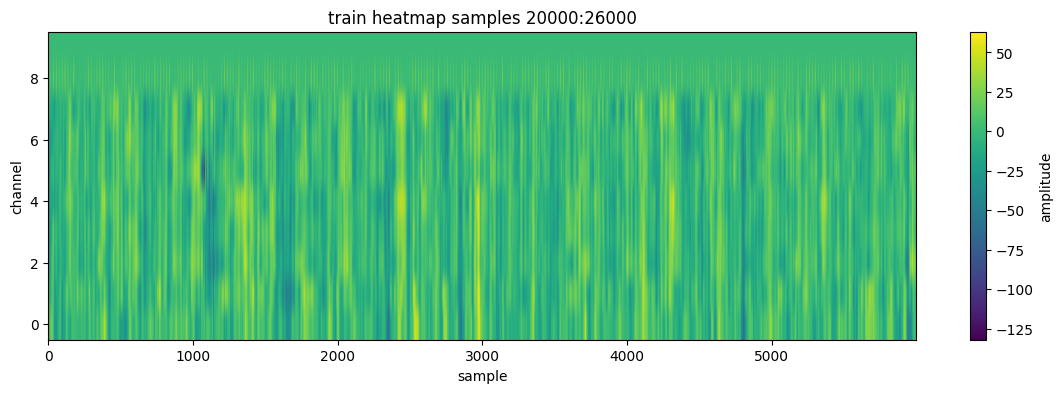

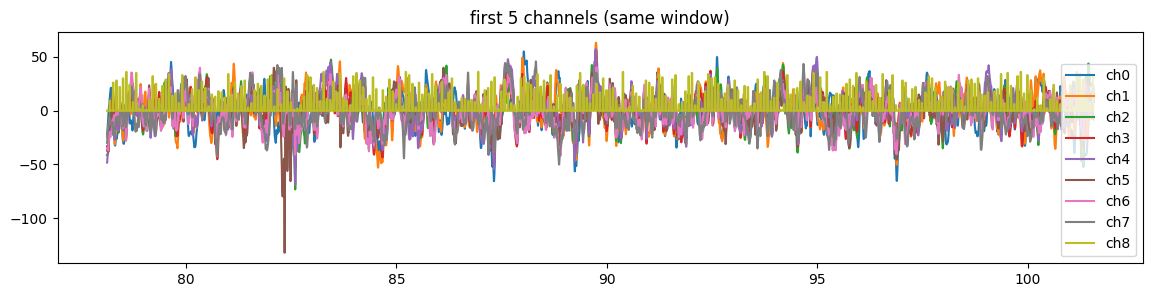

In [ ]:
# Plot custom window (set start_sample, window_samples)
start_sample = 20000
window_samples = 6000  # مثال: تعرض 20000:26000
end = min(sig_train.shape[1], start_sample + window_samples)

# heatmap
plt.figure(figsize=(14,4))
plt.imshow(sig_train[:, start_sample:end], aspect='auto', origin='lower')
plt.colorbar(label='amplitude')
plt.title(f"train heatmap samples {start_sample}:{end}")
plt.xlabel("sample")
plt.ylabel("channel")
plt.show()

# plot first 5 channels separately for the same window
nplot = min(9, sig_train.shape[0])
plt.figure(figsize=(14,3))
t_win = t_train[start_sample:end]
for i in range(nplot):
    plt.plot(t_win, sig_train[i, start_sample:end] + i*0, label=f"ch{i}")
plt.legend()
plt.title("first 5 channels (same window)")
plt.show()


In [ ]:
# Epoch extraction given event times or sample indices
# Inputs:
#   events_samples: array-like of sample indices (0-based) OR
#   events_seconds: array-like of event times in seconds (set one of them)
#   pre_s = 0.1   # seconds before event
#   post_s = 0.6  # seconds after event

events_samples = None
events_seconds = None
pre_s = 0.1
post_s = 0.6
sr = 256.0  # sampling rate detected earlier

# Example: if you have events in seconds, set events_seconds = [0.5, 1.2, ...]
# If you have sample indices, set events_samples = [128, 512, ...]

# Convert to sample indices
if events_samples is None and events_seconds is not None:
    events_samples = [int(round(t * sr)) for t in events_seconds]

if events_samples is None:
    print("No events provided. Set events_seconds or events_samples before running this cell.")
else:
    pre_samples = int(round(pre_s * sr))
    post_samples = int(round(post_s * sr))
    epoch_len = pre_samples + post_samples
    epochs = []  # shape: (n_events, n_channels, epoch_len)
    for es in events_samples:
        start = es - pre_samples
        end = es + post_samples
        if start < 0 or end > sig_train.shape[1]:
            # skip events too close to edges
            continue
        ep = sig_train[:, start:end].copy()
        epochs.append(ep)
    import numpy as np
    epochs = np.stack(epochs, axis=0)  # (n_events, n_channels, epoch_len)
    print("Extracted epochs shape:", epochs.shape)
    # compute ERP (average across events)
    erp = np.mean(epochs, axis=0)  # (n_channels, epoch_len)
    # plot ERP for channel 0
    times_epoch = np.linspace(-pre_s, post_s, epoch_len, endpoint=False)
    plt.figure(figsize=(8,3)); plt.plot(times_epoch, erp[0]); plt.title("ERP channel 0 (avg)"); plt.xlabel("s"); plt.show()


No events provided. Set events_seconds or events_samples before running this cell.


In [ ]:
sr = 256
pre_s = 0.1
post_s = 0.6
pre_samples = int(pre_s * sr)
post_samples = int(post_s * sr)

epochs = []
for e in edges:
    if e > pre_samples and e + post_samples < sig_train.shape[1]:
        ep = sig_train[:, e-pre_samples:e+post_samples]
        epochs.append(ep)

epochs = np.array(epochs)
print("Epochs shape:", epochs.shape)  # (n_events, 10, window_len)


NameError: name 'edges' is not defined

In [ ]:
erp = np.mean(epochs, axis=0)  # (10, epoch_len)
time_epoch = np.linspace(-pre_s, post_s, erp.shape[1])

plt.figure(figsize=(10,4))
plt.plot(time_epoch, erp[0], label='ch0 ERP')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Average ERP for ch0")
plt.legend()
plt.show()
